In [1]:
import os
import sys
import pickle
import re

import numpy as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib

sys.path.append("/home/axel/mercury_orbit")
sys.path.append("/home/axel/mercury_orbit/integrators_objects/")
from integrators.back_euler import BackEuler

from utils.integrator_object_utils import save_integrators

from scipy.signal import find_peaks
from scipy.stats import linregress

In [3]:
t_start = 0
t_end = 3000

M = 1
r = 9
#v = 0.345

#v = np.sqrt(M / r) + 0.01 * M / r
v = 0.375#np.sqrt(M / r) + 0.001 * M / r
initial_conditions = np.array([r, 0.0, 0, v / r])

dt_array = [0.5, 0.3, 0.1, 0.08, 0.05, 0.01]

## Euler back

In [3]:
back_euler_integrators = {}

#for dt in [0.1, 0.08, 0.05, 0.03, 0.01, 0.001]:
#for dt in [0.05, 0.03, 0.025, 0.02, 0.015, 0.01, 0.008, 0.005, 0.003, 0.001]:
for dt in dt_array:
    print(dt)  
    back_euler_integrator = BackEuler(initial_conditions, dt, t_end, t_start, M)
    back_euler_integrator.run_simulation()
    back_euler_integrators[str(dt)] = back_euler_integrator
    t_array = np.append(back_euler_integrator.t_array, t_end)
    # ax.plot(t_array, euler_forward_integrator.get_system_energy(), "-", label="Euler forward")

0.5
0.3
0.1
0.08
0.05
0.01


In [9]:
# Save integrators
save_dir = "../integrators_objects/0375_precession_study"
save_integrators(back_euler_integrators, "back_euler", save_dir)

In [2]:
# Import integrators
back_euler_integrators = {}

path = "../integrators_objects/0375_precession_study"

for file_name in os.listdir(path):
    if re.findall("back_euler", file_name):
        dt = re.findall("\d+\.\d+", file_name)[0]
        with open("{0}/{1}".format(path, file_name), "rb") as f:
            e = pickle.load(f)
            back_euler_integrators[str(dt)] = e

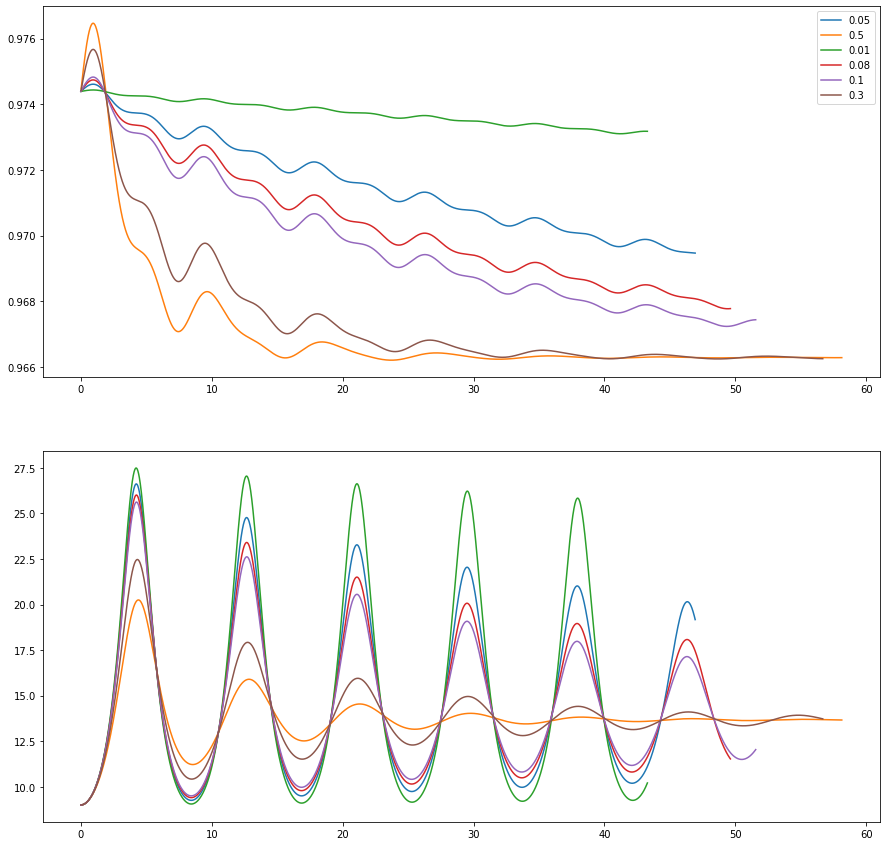

In [3]:
fig, axs = plt.subplots(2,1, figsize=(15,15))

for dt, integrator in back_euler_integrators.items():
    # if dt == "0.1":
    #     continue
    #axs[0].plot(np.append(integrator.t_array, t_end), integrator.get_system_energy(), label=dt)
    axs[0].plot(integrator.obs[:,2], integrator.get_system_energy(), label=dt)
    #axs[0].plot(np.append(integrator.t_array, t_end), integrator.obs[:,2], label=dt)
    axs[1].plot( integrator.obs[:,2], integrator.obs[:,0], label=dt)
    #axs[1].plot(integrator.obs[:,0]*np.cos(integrator.obs[:,2]), integrator.obs[:,0]*np.sin(integrator.obs[:,2]), label=dt)
# ax.plot(t_array, f)

axs[0].legend()

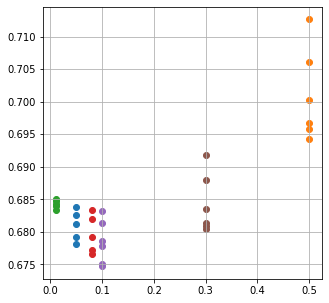

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

dts = [float(key) for key in back_euler_integrators.keys()]
change_avgs = []

# finding the perihelions
for dt, integrator in back_euler_integrators.items():
    # Finding valleys/perihelions
    peri_ind, _ = find_peaks(-integrator.obs[:,0])
    peri_ind = np.insert(peri_ind, 0, 0)
    # print(dt, integrator.obs[peri_ind, 2]/(2 * np.pi))
    change = np.diff(integrator.obs[peri_ind, 2]/(np.pi)) - 2
    change_avg = np.mean(change)
    change_avgs.append(change_avg)
    ax.scatter([float(dt)]*len(change), change)

result = linregress(dts, change_avgs)

#print(result)

ax.grid()

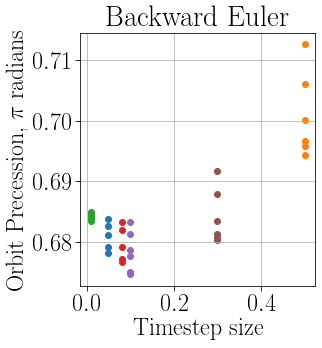

In [29]:
import utils.figure_generation
import importlib

importlib.reload(utils.figure_generation)

#for name, method_integrators in integrators.items():
title = "Backward Euler"
fig, ax = utils.figure_generation.generate_precession_graph(back_euler_integrators, title)

name = "back_euler"
fig.savefig("../report/figures/precession_analysis/"+name, dpi=600)

# Analysis of $h$ dependence (redacted)

dt =   0.5: a: -0.11293473908576494, b: -3.188766223898284
dt =   0.3: a: -0.17337203093585432, b: -3.8893751666801952
dt =   0.1: a: -0.3309117471126821 , b: -4.12708661349926
dt =  0.08: a: -0.2611923876585606 , b: -4.218659714065649
dt =  0.05: a: -0.17672924127889175, b: -4.2664548830257
dt =  0.01: a: -0.03536640512322823, b: -4.336431201875618


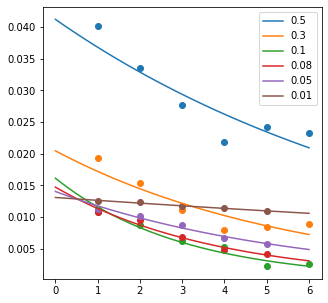

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for dt in dt_array:
    integrator = back_euler_integrators[str(dt)]
    peri_ind, _ = find_peaks(-integrator.obs[:,0])
    peri_ind = np.insert(peri_ind, 0, 0)
    # print(dt, integrator.obs[peri_ind, 2]/(2 * np.pi))
    change = np.diff(integrator.obs[peri_ind, 2])/np.pi - 2
    num_orbits = range(1, len(change)+1)

    converged_precession = 0.6725

    a, b = np.polyfit(num_orbits, np.log(change - converged_precession), 1)
    print("dt = {:5}: a: {:^20}, b: {:10}".format(dt, a, b))
    x_range = np.linspace(0, 6)

    ax.scatter(num_orbits, change - converged_precession)
    ax.plot(x_range, np.exp(b) * np.exp(a*x_range), label=dt)
ax.legend()

[-1.6474662292623658e-06, -1.239377745715473e-06, -4.185700375063577e-07, -2.129995444754048e-06, -2.292166047056132e-06, -1.8225398238827086e-06]


1.525877324147769e-08

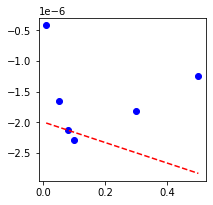

In [12]:
## INvestigating slope dependence
fig, ax = plt.subplots(1,1, figsize=(3,3))

dts = []
ks = []
ms = []

for dt_str, integrator in back_euler_integrators.items():
    dt = float(dt_str)
    reg_result = stats.linregress(np.append(integrator.t_array, t_end), integrator.get_system_energy())
    ax.scatter(dt, reg_result.slope, label=dt, c="blue")
    
    dts.append(dt)
    ks.append(reg_result.slope)
    ms.append(reg_result.intercept)
    
regreg_result = stats.linregress(dts, ks)    
print(ks)

ks = [x for _, x in sorted(zip(dts, ks), key=lambda pair: pair[0])]
ax.plot([min(dts), max(dts)], [ks[0] + regreg_result.intercept, ks[-1] + regreg_result.intercept], "--r")

regreg_result.slope
#generate_figure_loc(ax, fig, "figures/energy_conservation_euler_back.png")
